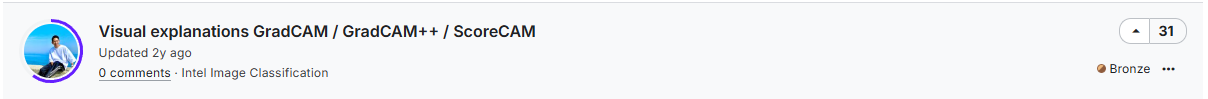

In [2]:
import os
import copy
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
SEED = 42
DIR_PATH = r"D:\code_study\ML_CODE\dataSets\IntelImageClassification\seg_train\seg_train"
W = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
LABEL_TO_CLASS = {
    "buildings": 0,
    "forest":    1,
    "glacier":   2,
    "mountain":  3,
    "sea":       4,
    "street":    5,
}
N_EPOCHS = 5
BATCH_SIZE = 32

In [4]:
CLASS_TO_LABEL = {v: k for k, v in LABEL_TO_CLASS.items()}
N_CLASSES = len(LABEL_TO_CLASS)
CLASS_TO_LABEL

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [5]:
def get_images(
        dir_path, 
        label_to_class, 
        w, 
        h, 
        seed,
    ):
    """Read images / labels from directory.
    
    Args:
        dir_path (str): Dir path saved data.
        label_to_class (dict[str, int]): Dict of label to class.
        w (int): Width size of image.
        h (int): Height size of image.
        seed (int): Random seed.
    
    Returns:
        tuple[np.ndarray, np.ndarray]: images, classes.
    """
    images = []
    classes = []
        
    for label_name in os.listdir(dir_path):
        cls = label_to_class[label_name]
        for img_name in os.listdir("/".join([dir_path, label_name])):
            img = load_img("/".join([dir_path, label_name, img_name]), target_size=(w, h))
            img = img_to_array(img)
            images.append(img)
            classes.append(cls)
            
    images = np.array(images, dtype=np.float32)
    classes = np.array(classes, dtype=np.float32)
    images, classes = shuffle(images, classes, random_state=seed)
    
    return images, classes

In [6]:
def split_dataset(
        images, 
        classes, 
        train_size=0.8, 
        test_size=0.2, 
        shuffle=False,
    ):
    """Split dataset.
    
    Args:
        images (np.ndarray): images.
        classes (np.ndarray): classes.
        train_size (float): Train data rate of split data.
        test_size (float): Test data rate of split data.
        shuffle (bool): Shuffle or not.
    
    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: X of train, y of train, X of test, y of test.
    """
    indices_train, indices_test = train_test_split(
        list(range(images.shape[0])), 
        train_size=train_size,
        test_size=test_size,
        shuffle=shuffle,
    )

    x_train = images[indices_train]
    y_train = classes[indices_train]
    x_test = images[indices_test]
    y_test = classes[indices_test]
    
    return x_train, y_train, x_test, y_test


In [7]:
def build_model(w, h, n_classes):
    """Build model function.
    
    Args:
        w (int): Width size of image.
        h (int): Height size of image.
        n_classes (int): The number of class.
        
    Returns:
        keras.engine.training.Model: Model.
    """ 
    # Resnet
    input_tensor = Input(shape=(w, h, 3)) # To change input shape
    resnet50 = ResNet50(
        include_top=False,                # To change output shape
        weights="imagenet",               # Use pre-trained model
        input_tensor=input_tensor,        # Change input shape for this task
    )
    
    # fc layer
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D())               # Add GAP for cam
    top_model.add(Dense(n_classes, activation="softmax")) # Change output shape for this task
    
    # model
    model = Model(inputs=resnet50.input, outputs=top_model(resnet50.output))
    
    # frozen weights
    for layer in model.layers[:-10]:
        layer.trainable = False or isinstance(layer, BatchNormalization) # If Batch Normalization layer, it should be trainable
        
    # compile
    model.compile(
        optimizer="adam", 
        loss="categorical_crossentropy", 
        metrics=["accuracy"],
    )
    
    return model


In [8]:
def plot_confusion_matrix(model, x_test, label_to_class):
    """Plot confusion matrix.
    
    Args:
        model (keras.engine.training.Model): Model.
        x_test (np.ndarray): X of test.
        label_to_class (dict[str, int]): Dict of label to class.
    """
    x = preprocess_input(copy.deepcopy(x_test))
    y_preds = model.predict(x)
    y_preds = np.argmax(y_preds, axis=1)
    y_trues = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_trues, y_preds)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar_kws={"shrink": .3}, linewidths=.1, ax=ax)
    ax.set(
        xticklabels=list(label_to_class.keys()),
        yticklabels=list(label_to_class.keys()),
        title="confusion matrix",
        ylabel="True label",
        xlabel="Predicted label",
    )
    params = dict(rotation=45, ha="center", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), **params)
    plt.setp(ax.get_xticklabels(), **params)
    plt.show()
    

In [9]:
def superimpose(img, cam):
    """Superimpose original image and cam heatmap.
    
    Args:
        img (np.ndarray): Image.
        cam (np.ndarray): Cam image.
        
    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: Image, heatmap, superimposed image.
    """
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8) # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return img, heatmap, superimposed_img

In [10]:
def plot_org_img_and_cam_heatmap(
        model, 
        cam_func, 
        superimpose, 
        img, 
        cls_true, 
        class_to_label, 
        cam_name,
    ):
    """Plot original image, heatmap from cam and superimpose image.
    
    Args:
        model (keras.engine.training.Model): Model.
        cam_func (function): Cam function.
        superimpose (function): Superimpose function.
        img (np.ndarray): Image.
        cls_true (float): Class of given img.
        class_to_label (dict[int, str]): Dict of class to label.
        cam_name (str): Used cam name.
    """
    # for cam
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title("original image")
    axs[0].axis("off")

    axs[1].imshow(heatmap)
    axs[1].set_title("heatmap")
    axs[1].axis("off")

    axs[2].imshow(superimposed_img)
    axs[2].set_title("superimposed image")
    axs[2].axis("off")

    title = "CAM name: " + cam_name + " / True label: " + class_to_label[cls_true] + " / Predicted label : " + class_to_label[cls_pred]
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [11]:
def grad_cam(model, x, layer_name):
    """Grad-CAM function.
    
    Args:
        model (keras.engine.training.Model): Model.
        x (np.ndarray): Input.
        layer_name (str): Get layer name
        
    Returns:
        tuple[int, np.ndarray]: Predicted class, heatmap of CAM.
    """
    # 预处理图像
    #x = tf.cast(x, tf.float32)
    cls = np.argmax(model.predict(x))
    
    #y_c = model.output[0, cls]
    #conv_output = model.get_layer(layer_name).output

    # 创建一个新的模型，输出包括最后一个卷积层的输出和最终的预测结果
    conv_output = model.get_layer(layer_name).output
    model_with_conv = Model(inputs=model.input, outputs=[conv_output, model.output])
        # 使用 tf.GradientTape 计算梯度
    with tf.GradientTape() as tape:
        inputs = tf.cast(x, tf.float32)
        conv_outputs, predictions = model_with_conv(inputs)
        loss = predictions[:, cls]

    grads = tape.gradient(loss, conv_outputs)[0]

    # # Get outputs and grads
    # gradient_function = K.function([model.input], [conv_output, grads])
    # output, grads_val = gradient_function([x])
    # output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    # weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling
    # # 生成激活图
    # cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)

        # 全局平均池化梯度
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        # 生成激活图
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)

    cam = np.maximum(cam, 0)  # 应用 ReLU
    cam = cam / np.max(cam)   # 归一化
    
    return cls, cam

In [12]:
'''def grad_cam_plus_plus(model, x, layer_name):
    """Grad-CAM++ function.
    
    Args:
        model (keras.engine.training.Model): Model.
        x (np.ndarray): Input.
        layer_name (str): Get layer name.
        
    Returns:
        tuple[int, np.ndarray]: Predicted class, heatmap of CAM.
    """
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.GradientTape().gradient(y_c, conv_output)[0]

    # first / second / third derivative
    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    # Get outputs, grads and higher order derivatives
    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])
    
    # Calculate weight alpha
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)
    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0)
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[2]))
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[2])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=2) # multiply
    cam = np.maximum(cam, 0)                                          # Passing through ReLU
    cam /= np.max(cam)                                                # scale 0 to 1.0  

    return cls, cam
    '''

'def grad_cam_plus_plus(model, x, layer_name):\n    """Grad-CAM++ function.\n    \n    Args:\n        model (keras.engine.training.Model): Model.\n        x (np.ndarray): Input.\n        layer_name (str): Get layer name.\n        \n    Returns:\n        tuple[int, np.ndarray]: Predicted class, heatmap of CAM.\n    """\n    cls = np.argmax(model.predict(x))\n    y_c = model.output[0, cls]\n    conv_output = model.get_layer(layer_name).output\n    grads = tf.GradientTape().gradient(y_c, conv_output)[0]\n\n    # first / second / third derivative\n    first = K.exp(y_c) * grads\n    second = K.exp(y_c) * grads * grads\n    third = K.exp(y_c) * grads * grads * grads\n\n    # Get outputs, grads and higher order derivatives\n    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])\n    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])\n    \n    # Calculate weight alpha\n    global_sum = np.sum(co

In [13]:
   # 预处理图像
def grad_cam_plus_plus(model, x, layer_name):
    """Grad-CAM++ function.
    
    Args:
        model (keras.engine.training.Model): Model.
        x (np.ndarray): Input.
        layer_name (str): Get layer name.
        
    Returns:
        tuple[int, np.ndarray]: Predicted class, heatmap of CAM.
    """
    x = tf.cast(x, tf.float32)
    
    # 获取模型的预测类别
    cls = np.argmax(model.predict(x))
    
    # 创建一个新的模型，输出包括最后一个卷积层的输出和最终的预测结果
    conv_output = model.get_layer(layer_name).output
    model_with_conv = Model(inputs=model.input, outputs=[conv_output, model.output])
    
    # 使用 tf.GradientTape 计算梯度
    with tf.GradientTape(persistent=True) as tape:
        inputs = tf.cast(x, tf.float32)
        conv_outputs, predictions = model_with_conv(inputs)
        loss = predictions[:, cls]
    
    # 计算梯度
    grads = tape.gradient(loss, conv_outputs)
    first = tf.exp(loss) * grads
    second = tf.exp(loss) * grads * grads
    third = tf.exp(loss) * grads * grads * grads
    
    # 全局平均池化梯度
    global_sum = tf.reduce_sum(conv_outputs[0], axis=(0, 1))
    alpha_num = second[0]
    alpha_denom = second[0] * 2.0 + third[0] * global_sum
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
    alphas = alpha_num / alpha_denom

    weights = tf.maximum(grads[0], 0.0)
    alpha_normalization_constant = tf.reduce_sum(alphas, axis=(0, 1))
    alphas /= alpha_normalization_constant

    deep_linearization_weights = tf.reduce_sum(weights * alphas, axis=(0, 1))

    cam = tf.reduce_sum(deep_linearization_weights * conv_outputs[0], axis=-1)
    cam = tf.maximum(cam, 0)  # 应用 ReLU
    cam = cam / tf.reduce_max(cam)  # 归一化
    
    return cls, cam.numpy()

In [14]:
def softmax(x):
    """Softmax function.
    
    Args:
        x (np.ndarray): Input.
        
    Returns:
        np.ndarray: Softmax(x)
    """
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [15]:
def score_cam(
        model, 
        x, 
        layer_name, 
        max_N=-1,
    ):
    """Score-CAM function.
    
    Args:
        model (keras.engine.training.Model): Model.
        x (np.ndarray): Input.
        layer_name (str): Get layer name.
        max_N (int): max N.
        
    Returns:
        tuple[int, np.ndarray]: Predicted class, heatmap of CAM.
    """
    cls = np.argmax(model.predict(x))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(x)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0, :, :, k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:, :, :, max_N_indices]

    input_shape = model.layers[0].output_shape[1:]  # get input shape
    
    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
        
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(x)
        for k in range(3):
            masked_input[0, :, :, k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:, cls]
    
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0, :, :, :], weights) # multiply
    cam = np.maximum(0, cam)                         # Passing through ReLU
    cam /= np.max(cam)                               # scale 0 to 1.0
    
    return cls, cam

In [16]:
def compare_each_cam(
        images, 
        classes, 
        class_to_label, 
        model, 
        grad_cam, 
        grad_cam_plus_plus, 
        score_cam, 
        superimpose, 
        layer_name, 
        target_cls,
    ):
    """Compare Grad-CAM / Grad-CAM++ / Score-CAM on target class images.
    
    Args:
        images (np.ndarray): images.
        classes (np.ndarray): classes.
        class_to_label (dict[int, str]): Dict of class to label.
        model (keras.engine.training.Model): Model.
        grad_cam (function): Grad-CAM function.
        grad_cam_plus_plus (function): Grad-CAM++ function.
        score_cam (function): Score-CAM function.
        superimpose (function): Superimpose function.
        layer_name (str): Get layer name.
        target_cls (int): Target class.
    """
    indices = np.where(classes == target_cls)[0]
    label = class_to_label[target_cls]

    n_cols = 10 # # of sample plot

    fig, axs = plt.subplots(ncols=n_cols, nrows=4, figsize=(25, 9))

    for i in range(n_cols):
        
        img = images[indices[i]]
        
        # for cam
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(copy.deepcopy(x))

        # original
        axs[0, i].imshow(np.uint8(img))
        axs[0, i].set_title(label)
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        if i == 0:
            axs[0, i].set_ylabel("Original", rotation=0, ha="right")

        # Grad-CAM
        cls_pred, cam = grad_cam(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam = superimpose(img, cam)
        axs[1, i].imshow(img_grad_cam)
        axs[1, i].set_title("pred: " + class_to_label[cls_pred])
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        if i == 0:
            axs[1, i].set_ylabel("Grad-CAM", rotation=0, ha="right")

        # Grad-CAM++
        cls_pred, cam = grad_cam_plus_plus(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam_plus_plus = superimpose(img, cam)
        axs[2, i].imshow(img_grad_cam_plus_plus)
        axs[2, i].set_title("pred: " + class_to_label[cls_pred])
        axs[2, i].set_xticks([])
        axs[2, i].set_yticks([])
        if i == 0:
            axs[2, i].set_ylabel("Grad-CAM++", rotation=0, ha="right")

        # Score-CAM
        cls_pred, cam = score_cam(model=model, x=x, layer_name=layer_name)
        _, _, img_score_cam = superimpose(img, cam)
        axs[3, i].imshow(img_score_cam)
        axs[3, i].set_title("pred: " + class_to_label[cls_pred])
        axs[3, i].set_xticks([])
        axs[3, i].set_yticks([])
        if i == 0:
            axs[3, i].set_ylabel("Score-CAM", rotation=0, ha="right")

    plt.show()

In [17]:
images, classes = get_images(
    dir_path=DIR_PATH, 
    label_to_class=LABEL_TO_CLASS,
    w=W,
    h=H,
    seed=SEED,
)

images.shape, classes.shape

((14034, 112, 112, 3), (14034,))

In [18]:
# Check the number of images for each labels

n_total_images = images.shape[0]
for target_cls in list(CLASS_TO_LABEL.keys()):
    indices = np.where(classes == target_cls)[0] # get target class indices on images / classes
    n_target_cls = indices.shape[0]
    label = CLASS_TO_LABEL[target_cls]
    print(label, ":", n_target_cls, round(n_target_cls / n_total_images, 2))

buildings : 2191 0.16
forest : 2271 0.16
glacier : 2404 0.17
mountain : 2512 0.18
sea : 2274 0.16
street : 2382 0.17


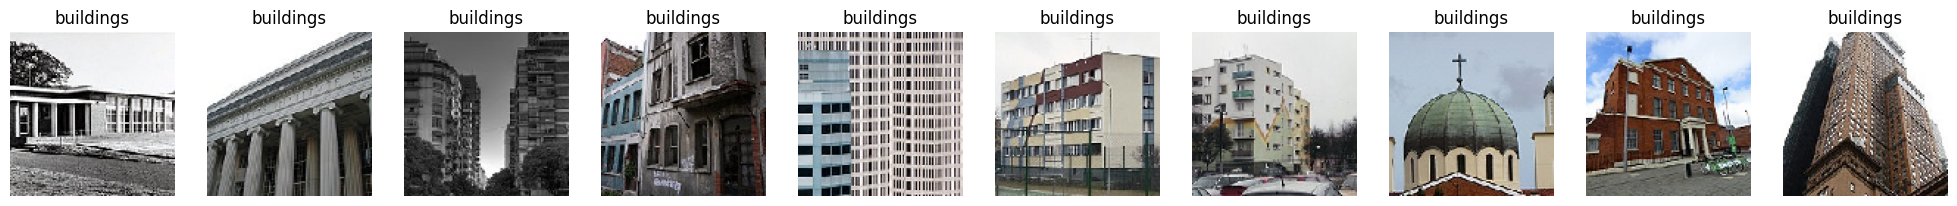

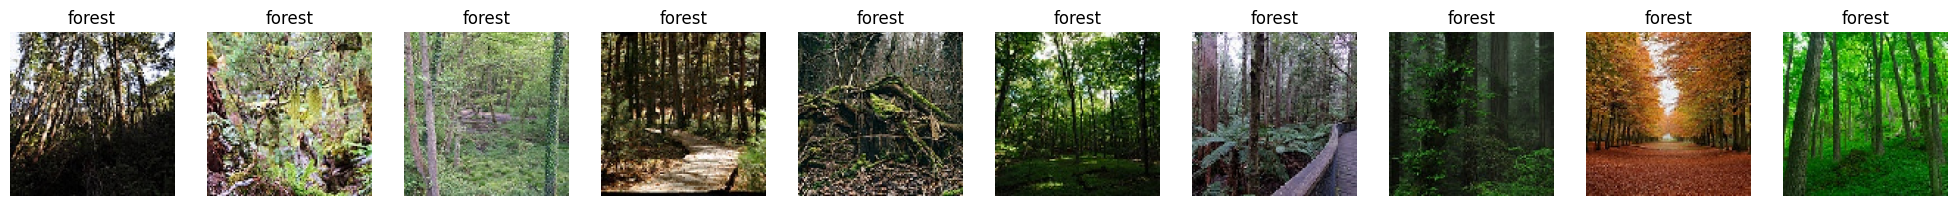

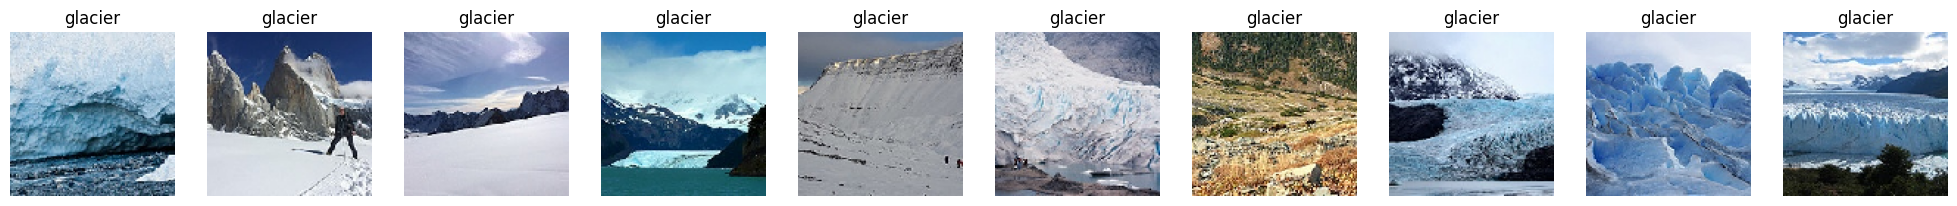

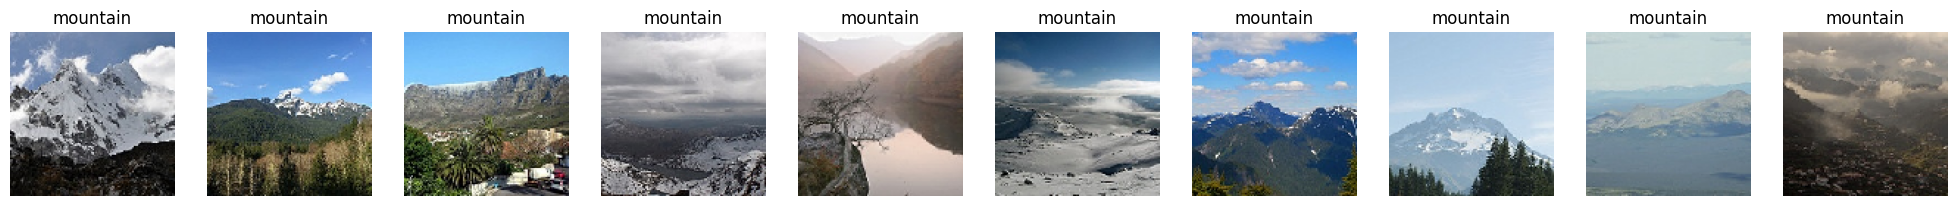

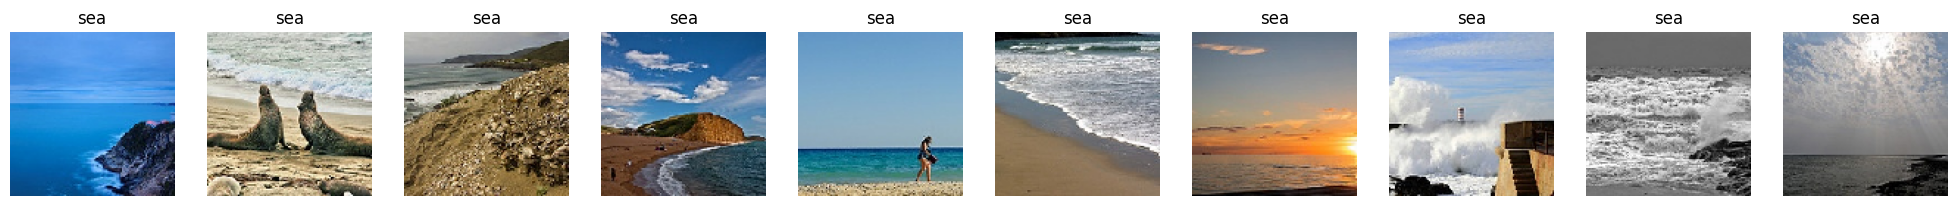

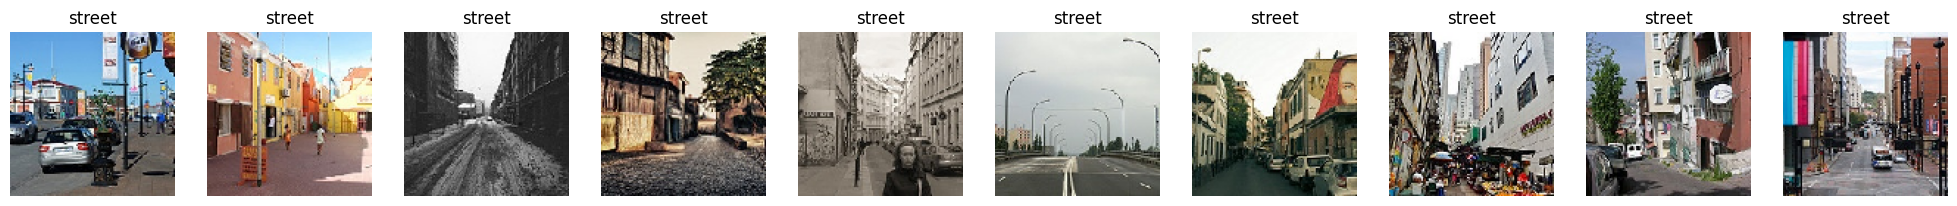

In [19]:
# Visualize some images / labels

for target_cls in list(CLASS_TO_LABEL.keys()):
    indices = np.where(classes == target_cls)[0] # get target class indices on images / classes
    label = CLASS_TO_LABEL[target_cls]

    n_cols = 10 # The number of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):
        axs[i].imshow(np.uint8(images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

In [20]:
# split dataset to train and test

x_train, y_train, x_test, y_test = split_dataset(images, classes)

# to one-hot

y_train = keras.utils.to_categorical(y_train, N_CLASSES)
y_test = keras.utils.to_categorical(y_test, N_CLASSES)

# To image data generator
# Use image data augmentation for train data

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    zoom_range=0.1,                          # Randomly zoom image
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [21]:
model = build_model(w=W, h=H, n_classes=N_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 118, 118, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 56, 56, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 56, 56, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [22]:
history = model.fit_generator(
    datagen_train.flow(
        x_train, 
        y_train, 
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test, 
        y_test, 
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
351/351 [==============================] - 40s 101ms/step - loss: 0.7131 - accuracy: 0.7583 - val_loss: 0.2841 - val_accuracy: 0.8992
Epoch 2/5
351/351 [==============================] - 32s 92ms/step - loss: 0.3352 - accuracy: 0.8821 - val_loss: 0.2771 - val_accuracy: 0.9006
Epoch 3/5
351/351 [==============================] - 33s 93ms/step - loss: 0.2855 - accuracy: 0.9025 - val_loss: 0.2483 - val_accuracy: 0.9177
Epoch 4/5
351/351 [==============================] - 33s 93ms/step - loss: 0.2564 - accuracy: 0.9052 - val_loss: 0.2695 - val_accuracy: 0.9038
Epoch 5/5
351/351 [==============================] - 33s 93ms/step - loss: 0.2316 - accuracy: 0.9152 - val_loss: 0.2442 - val_accuracy: 0.9216


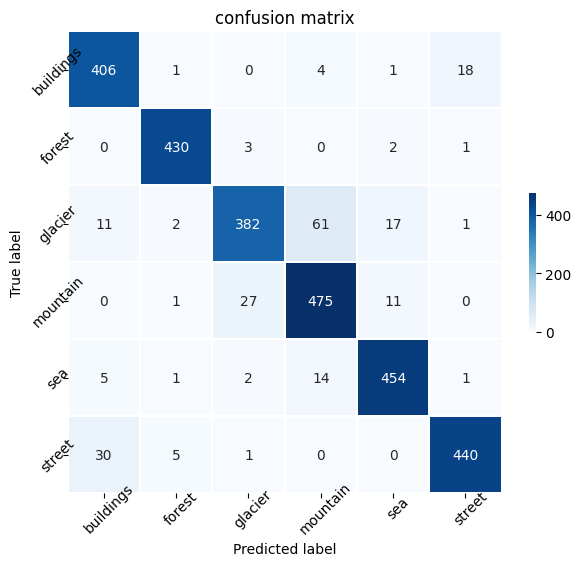

In [23]:
# Confirm the result of finetuning
# Plot the confusion matrix

plot_confusion_matrix(model, x_test, LABEL_TO_CLASS)

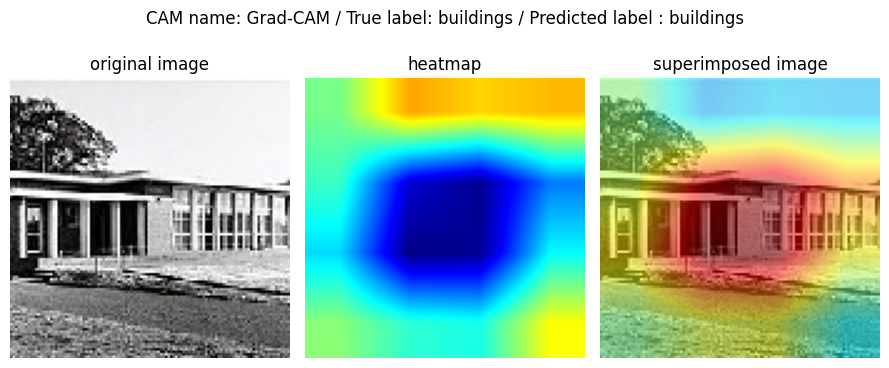

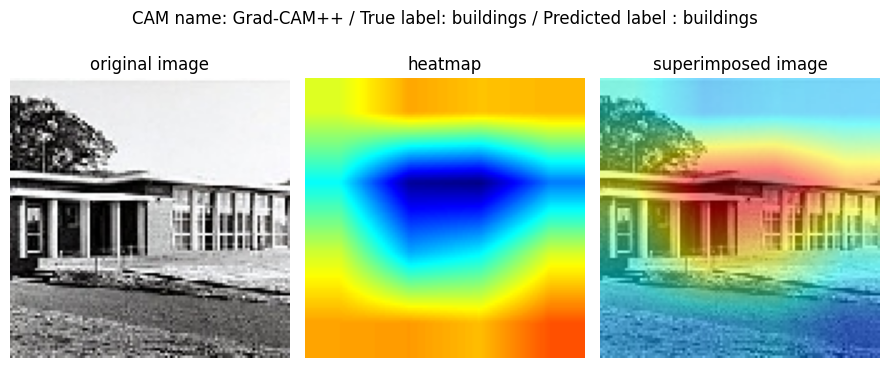

In [24]:
plot_org_img_and_cam_heatmap(
    model=model, 
    cam_func=grad_cam,
    superimpose=superimpose,
    img=images[0],
    cls_true=classes[0], 
    class_to_label=CLASS_TO_LABEL, 
    cam_name="Grad-CAM",
)
plot_org_img_and_cam_heatmap(
    model=model, 
    cam_func=grad_cam_plus_plus,
    superimpose=superimpose,
    img=images[0], 
    cls_true=classes[0], 
    class_to_label=CLASS_TO_LABEL,
    cam_name="Grad-CAM++",
)
# plot_org_img_and_cam_heatmap(
#     model=model, 
#     cam_func=score_cam,
#     superimpose=superimpose,
#     img=images[0], 
#     cls_true=classes[0], 
#     class_to_label=CLASS_TO_LABEL, 
#     cam_name="Score-CAM",
# )


In [25]:
for k, v in LABEL_TO_CLASS.items():
    compare_each_cam(
        images=images, 
        classes=classes, 
        class_to_label=CLASS_TO_LABEL,
        model=model,
        grad_cam=grad_cam, 
        grad_cam_plus_plus=grad_cam_plus_plus, 
        score_cam=score_cam, 
        superimpose=superimpose, 
        layer_name=model.layers[-2].name, 
        target_cls=v,
    )

: 

: 

In [ ]:
!pip freeze > requirements.txt
!python --version > py_ver.txt
!cat /proc/driver/nvidia/version > nvidia_ver.txt